In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import datetime as dt
import os

"""
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
os.environ['CUDA_VISIBLE_DEVICES']='0'
"""
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(tf.__version__)
print(gpus)

2.4.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
solve_cudnn_error()

1 Physical GPUs, 1 Logical GPUs


import tensorflow as tf
from tensorflow.keras import * 
import time

tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

t=time.time()
with tf.device("/gpu:0"):
    tf.random.set_seed(0)
    a = tf.random.uniform((10000,10000),minval = 0,maxval = 3.0)
    c = tf.matmul(a, tf.transpose(a))
    d = tf.reduce_sum(c)
print('gpu: ', time.time()-t)

t=time.time()
with tf.device("/cpu:0"):
    tf.random.set_seed(0)
    a = tf.random.uniform((10000,10000),minval = 0,maxval = 3.0)
    c = tf.matmul(a, tf.transpose(a))
    d = tf.reduce_sum(c)
print('cpu: ', time.time()-t)

# STAR train

In [2]:
# Ho
import os
import cv2 
import numpy as np
from PIL import Image
import pandas as pd

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers,models,optimizers


from sklearn.model_selection import train_test_split


img_resize=(224,224)
def ReFileName(dirPath):
    mango=[]
    for file in os.listdir(dirPath):
        if os.path.isfile(os.path.join(dirPath, file)) == True:
           c= os.path.basename(file)
           name = dirPath + '\\' + c
           img = cv2.imread(name)
           img=cv2.resize(img,img_resize)
           mango.append(img)
    return mango

In [3]:
#圖片路徑

train_dir = r'C:\Users\lab543\Desktop\DATA\Train_Image'
dirPath = r"C:\Users\lab543\Desktop\DATA\Train_Image"
valid_dir  = r'C:\Users\lab543\Desktop\DATA\Test_Image'


# train_dir = r'D:\_YUN\24_ML\Work02\Mango\DATA'
# dirPath =train_dir+ r'\Train_Image_512'


#標籤路徑
train_label = pd.read_csv(train_dir+ r'\..\train.csv',header = 0)

#One-hot
train_label = train_label['label'].map({"A":0, "B":1,"C":2})
train_label = to_categorical(train_label)

mango = ReFileName(dirPath)
datas=np.array(mango).astype('float32')/255.0

In [4]:

#切割
train_data, val_data, train_label, val_label = train_test_split(datas, train_label, test_size=0.2, random_state=0)


BATCH_SIZE = 512
SHUFFLE_BUFFER_SIZE = 100

tensor_train_data=tf.constant(train_data)
tensor_train_label=tf.constant(train_label,dtype=tf.int32)

train_dataset = tf.data.Dataset.from_tensor_slices((tensor_train_data, tensor_train_label))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)


print( 'train_dataset =', train_dataset )

train_dataset = <BatchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.int32)>


# 建立模型

In [5]:
# Ho 128->256   base_model = layers.Conv2D(256, (1, 1), padding='valid')(base_model)

from tensorflow.keras.applications.vgg16 import VGG16
def create_model():
    net = VGG16(include_top=False, weights='imagenet', input_tensor=None,
          input_shape = (train_data.shape[1],train_data.shape[2],train_data.shape[3])
          )
    l2 = tf.keras.regularizers.l2(0.01)

    # 透過layer_name 節取 model的某一層 block3_pool block4_conv3
    layer_name='block4_pool'

    # 設定取到該層的都使用預設參數，不訓練參數
    layer_index=net.layers.index(net.get_layer(layer_name))

    # 建立模型
    base_model = net.get_layer(layer_name).output
    base_model = layers.Conv2D(256, (1, 1), padding='valid')(base_model)
    base_model = layers.MaxPooling2D( pool_size = (3, 3) )(base_model)

    # 攤平 feature map 
    base_model = layers.Flatten()(base_model)


    base_model = layers.Dropout(0.3)(base_model)
    base_model = layers.BatchNormalization()(base_model)
    base_model = layers.Dense(units = 256, kernel_initializer = tf.keras.initializers.GlorotNormal()
             ,kernel_regularizer= l2 , activation= 'relu')(base_model)


    base_model = layers.Dense(units = 256, kernel_initializer = tf.keras.initializers.GlorotNormal()
             ,kernel_regularizer = l2 , activation= 'relu')(base_model)

    base_model = layers.Dropout(0.3)(base_model)
    output_layer = layers.Dense(train_label.shape[1], activation='softmax', name='softmax')(base_model)

    # 設定凍結與要進行訓練的網路層
    net_final = tf.keras.models.Model(inputs=net.input, outputs=output_layer)

    for layer in net_final.layers[:layer_index]:
        layer.trainable = False

    return net_final

test_model=create_model()
test_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#  compile fit  callbacks 設定

In [6]:
# Ho

# 
# Generate batches of tensor image data with real-time data augmentation.

train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=15 , 
                             width_shift_range=0.2 , 
                             height_shift_range=0.2 ,
                             shear_range=0.2 ,
                             zoom_range=0.2 , 
                             data_format='channels_last')

callbacks_list=[
        tf.keras.callbacks.EarlyStopping(
          monitor='val_loss',mode='min', patience=18 ,restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath='C:/Users/lab543/Desktop/DATA/Mango_VGG16_01',
            monitor='val_loss',
            save_best_only=True,
        ),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy',
                             patience=3,
                             # 3 epochs 內acc沒下降就要調整LR
                             verbose=1,
                             factor=0.5,
                             # LR降為0.5
                             min_lr=0.00001
                             # 最小 LR 到0.00001就不再下降
                             )]

precision=tf.keras.metrics.Precision(name='precision')
recall=tf.keras.metrics.Recall(name='recall')
accuracy=tf.keras.metrics.CategoricalAccuracy(name='accuracy')


test_model.compile(optimizer='Adam' , loss='categorical_crossentropy' , metrics=[precision,recall,accuracy])
history=test_model.fit(train_datagen.flow(train_data,train_label,batch_size=128),
                       epochs=30,
                       validation_data=(val_data,val_label),
                       callbacks=callbacks_list)


Epoch 1/30
39/39 [==============================] - 46s 955ms/step - loss: 7.6517 - precision: 0.4745 - recall: 0.3446 - accuracy: 0.4532 - val_loss: 6.1058 - val_precision: 0.5416 - val_recall: 0.5359 - val_accuracy: 0.5383
INFO:tensorflow:Assets written to: C:/Users/lab543/Desktop/DATA\Mango_VGG16_01\assets
Epoch 2/30
39/39 [==============================] - 33s 848ms/step - loss: 5.0455 - precision: 0.6617 - recall: 0.5282 - accuracy: 0.6175 - val_loss: 3.6353 - val_precision: 0.7047 - val_recall: 0.6501 - val_accuracy: 0.6827
INFO:tensorflow:Assets written to: C:/Users/lab543/Desktop/DATA\Mango_VGG16_01\assets
Epoch 3/30
39/39 [==============================] - 32s 824ms/step - loss: 3.3032 - precision: 0.7007 - recall: 0.5964 - accuracy: 0.6695 - val_loss: 2.4339 - val_precision: 0.6898 - val_recall: 0.6566 - val_accuracy: 0.6803
INFO:tensorflow:Assets written to: C:/Users/lab543/Desktop/DATA\Mango_VGG16_01\assets
Epoch 4/30
39/39 [==============================] - 32s 826ms/step 

#   畫 train 圖  、評估測試

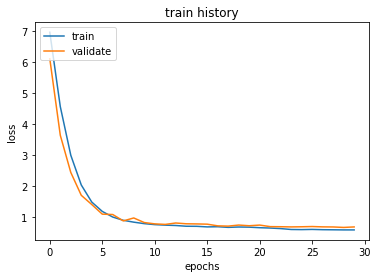

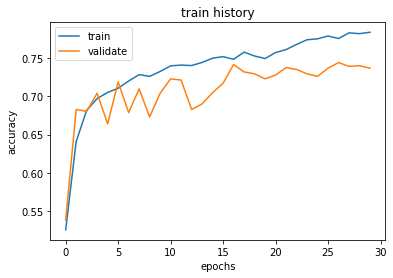

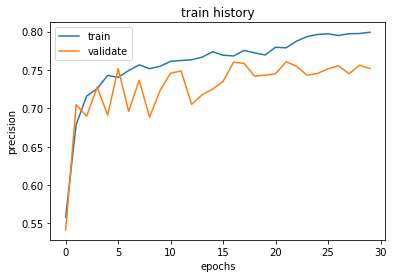

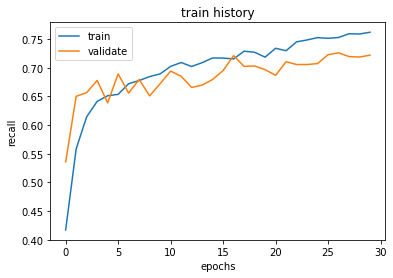

In [8]:
# HO
import matplotlib.pyplot as plot  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import datetime as dt
import os
def train_history_graphic( history       # 資料集合
              , history_key1  # 資料集合裡面的來源 1 (有 loss, acc, val_loss, val_acc 四種)
              , history_key2  # 資料集合裡面的來源 2 (有 loss, acc, val_loss, val_acc 四種)
              , y_label       # Y 軸標籤文字
                         ) :
    # 資料來源 1
    plot.plot( history.history[history_key1] )
    # 資料來源 2
    plot.plot( history.history[history_key2] )
    # 標題
    plot.title( 'train history' )

    # X 軸標籤文字
    plot.xlabel( 'epochs' )

    # Y 軸標籤文字
    plot.ylabel( y_label )

    # 設定圖例
    # (參數 1 為圖例說明, 有幾個資料來源, 就對應幾個圖例說明)
    # (參數 2 為圖例位置, upper 為上面, lower 為下面, left 為左邊, right 為右邊)
    plot.legend( ['train', 'validate']
               , loc = 'upper left'
               )

    # 顯示畫布
    plot.show()

train_history_graphic( history, 'loss', 'val_loss', 'loss' )
train_history_graphic( history, 'accuracy', 'val_accuracy', 'accuracy' )
train_history_graphic( history, 'precision', 'val_precision', 'precision' )
train_history_graphic( history, 'recall', 'val_recall', 'recall' )




# 顯示 Model 評估測試資料的
# preds=test_model.evaluate(test_data,test_label)

# print('loss ： %.5f' % preds[0])
# print('precision：%.5f' % preds[1])
# print('recall：%.5f' % preds[2])
# print('accuracy： %.5f' % preds[3])
# F1 = 2 * (preds[3] * preds[2]) / (preds[3] + preds[2])
# print('f1score：%.5f' % F1)

# load_model 預測

In [10]:
# 2021-04-23 load_model

test_model = keras.models.load_model('C:/Users/lab543/Desktop/DATA/Mango_VGG16_01')

In [ ]:

TestdirPath = r"D:\_YUN\24_ML\Work02\Mango\DATA\Test_Image"
Testmango = ReFileName(TestdirPath)

#標籤路徑
test_label = pd.read_csv(r'D:\_YUN\24_ML\Work02\Mango\DATA\test.csv',header = 0)

#One-hot
test_label = test_label['label'].map({"A":0, "B":1,"C":2})
test_label = to_categorical(test_label)

test_data=np.array(Testmango).astype('float32')/255

In [ ]:
print( 'test_data =', test_data.shape )
print( 'test_label =', test_label.shape )

In [ ]:
BATCH_SIZE = 128
tensor_test_data=tf.constant(test_data)
tensor_test_label=tf.constant(test_label)
# test_dataset = tf.data.Dataset.from_tensors((tensor_test_data, tensor_test_label))
test_dataset = tf.data.Dataset.from_tensor_slices((tensor_test_data, tensor_test_label))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
# 顯示 Model 評估測試資料的
preds=test_model.evaluate(test_dataset)

print('loss ： %.5f' % preds[0])
print('precision：%.5f' % preds[1])
print('recall：%.5f' % preds[2])
print('accuracy： %.5f' % preds[3])
F1 = 2 * (preds[3] * preds[2]) / (preds[3] + preds[2])
print('f1score：%.5f' % F1)